# Imports, loading and downloads

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from loads import *

PATH_FOLDER = "MovieSummaries/"

In [3]:
# Loading character metadata DataFrame
character_df = load_character_metadata()
# Loading movie metadata DataFrame
movie_df = load_movie_metadata()
# Loading plot summaries DataFrame
plot_summaries_df = load_plot_summaries()
# Loading TVTropes DataFrame
tvtropes_df = load_tvtropes()
# Loading name clusters DataFrame
name_clusters_df = load_name_clusters()
# Loading inflation DataFrame
inflation = pd.read_excel("external_dataset/inflation.xlsx", header=11)

C:\Users\ratas\.conda\envs\ada\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


# Preprocessing

#### MOVIE METADATA Cleaning

We are first extracting variables that have the form (ID : variable) tuples to be able to use these features.

In [4]:
# Extracting and transforming the 'Movie languages (Freebase ID:name tuples)' column
# Applying a lambda function to convert the JSON-like string to a list of language names
movie_df['Movie Languages'] = movie_df['Movie languages (Freebase ID:name tuples)'].apply(lambda x: list(json.loads(x).values()))
# Extracting and transforming the 'Movie countries (Freebase ID:name tuples)' column
# Applying a lambda function to convert the JSON-like string to a list of country names
movie_df['Movie Countries'] = movie_df['Movie countries (Freebase ID:name tuples)'].apply(lambda x: list(json.loads(x).values()))
# Extracting and transforming the 'Movie genres (Freebase ID:name tuples)' column
# Applying a lambda function to convert the JSON-like string to a list of genre names
movie_df['Movie Genres'] = movie_df['Movie genres (Freebase ID:name tuples)'].apply(lambda x: list(json.loads(x).values()))

A lot of columns in the dataframe contain IDs that we don't need, we are thus, dropping them.

In [5]:
# List of columns to be dropped from the DataFrame
movie_columns_to_drop = ['Movie languages (Freebase ID:name tuples)', 'Movie countries (Freebase ID:name tuples)','Movie genres (Freebase ID:name tuples)','Freebase movie ID']
# Dropping specified columns from the DataFrame
movie_df.drop(movie_columns_to_drop, axis=1, inplace=True)

Our main interest is to see what features result in higher boxe office revenues, so we need to drop movies with missing revenue (Nan).

In [6]:
# Dropping rows from the DataFrame where 'Movie box office revenue' is NaN
movie_df.dropna(subset=['Movie box office revenue'], inplace=True)

One of our feature of interest is the release date of the movies. We are thus, processing the column, for it to be usable in our analysis. We extract Year and Month from the Movie release date (date format YYYY and YYYY-MM-DD can't be dealt together).

In [7]:
# Dropping rows where 'Movie release date' is NaN
movie_df.dropna(subset=["Movie release date"], inplace=True)
# Create a Year column in the movie dataframe
movie_df['Year'] = movie_df["Movie release date"].apply(lambda x: str(x)[:4]).astype(int)
# Create a Month column in the movie dataframe
movie_df['Month'] = pd.to_datetime(movie_df['Movie release date'],errors='coerce').dt.month

#### Inflation

To be able to compare the the relative box office revenues across different years, we need to take inflation into account.

In [8]:
# Calculate cumulative inflation to 2022 using the last available annual inflation rate
inflation["Cumulative Inflation to 2022"] = inflation.iloc[-1].Annual / inflation["Annual"]
# Merge the movie DataFrame with the inflation DataFrame on the 'Year' column
movie_with_inflation = pd.merge(movie_df, inflation, on='Year')
# Calculate revenue with inflation by multiplying 'Movie box office revenue' with the 'Cumulative Inflation to 2022'
movie_with_inflation['Revenue with inflation'] = movie_with_inflation['Movie box office revenue'] * movie_with_inflation['Cumulative Inflation to 2022']
movie_with_inflation.drop(['Cumulative Inflation to 2022', 'Annual'], axis=1, inplace=True)

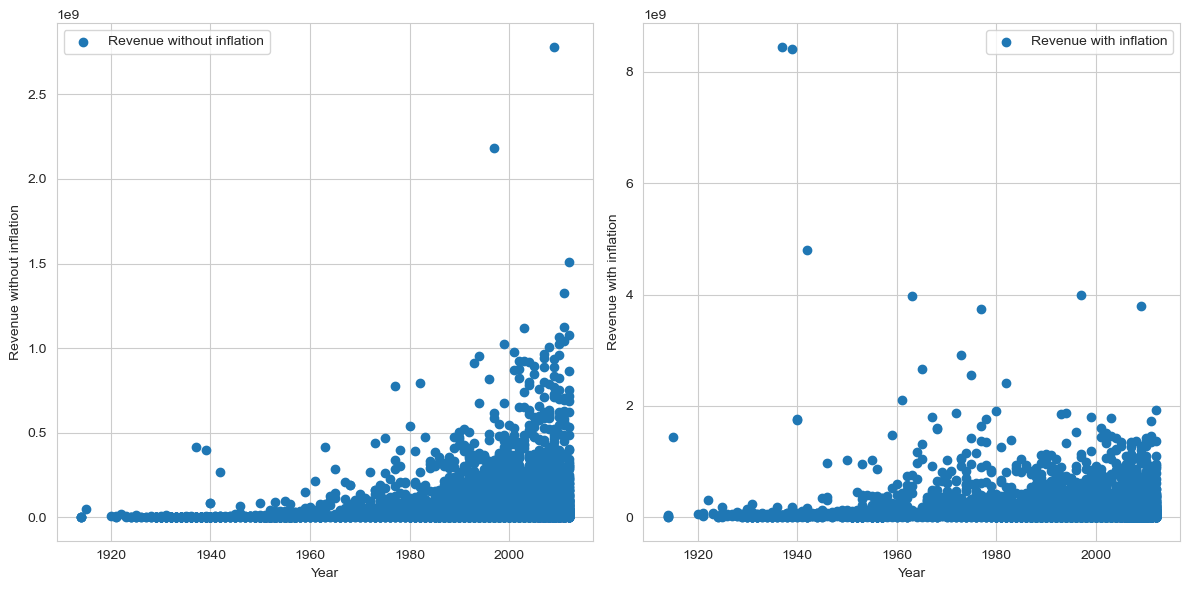

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Plot for Revenue without inflation
ax1.scatter(movie_with_inflation['Year'], movie_with_inflation['Movie box office revenue'], label='Revenue without inflation')
ax1.set_xlabel('Year')
ax1.set_ylabel('Revenue without inflation')
ax1.legend()

# Plot for Revenue with inflation
ax2.scatter(movie_with_inflation['Year'], movie_with_inflation['Revenue with inflation'], label='Revenue with inflation')
ax2.set_xlabel('Year')
ax2.set_ylabel('Revenue with inflation')
ax2.legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

The original distribution of the inflated movie box office revenue exhibits a heavy-tailed pattern, with a few movies achieving extremely high revenues. By applying a logarithmic transformation on the x-axis, we approximate a "more" normal distribution, making the data more amenable to statistical analyses that assume normality.

Text(0, 0.5, 'Number of movies')

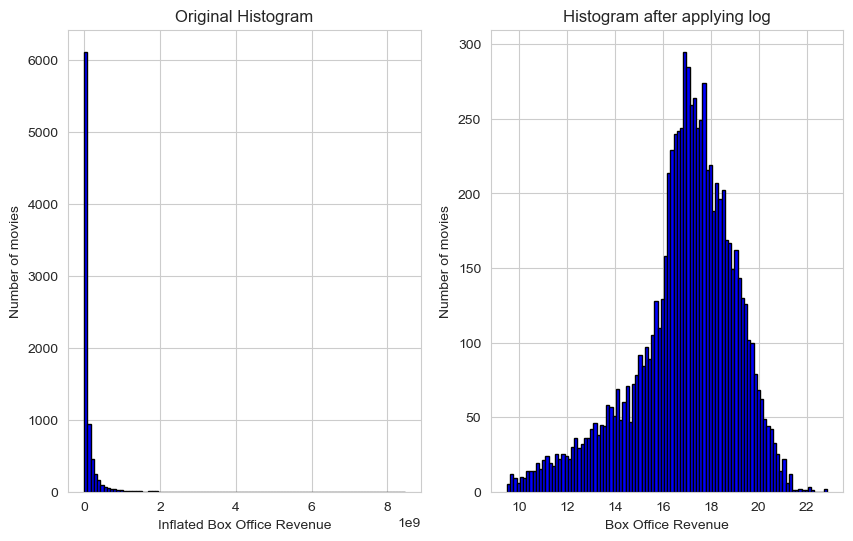

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# Plotting the original distribution and the distribution after applying log function on the revenue feature
movie_with_inflation['Revenue with inflation'].hist(ax=axs[0], bins=100, color='blue', edgecolor='black')
movie_with_inflation['log_revenues'] = np.log(movie_with_inflation['Revenue with inflation'])
movie_with_inflation['log_revenues'].hist(ax=axs[1], bins=100, color='blue', edgecolor='black')
axs[0].set_title('Original Histogram')
axs[0].set_xlabel('Inflated Box Office Revenue')
axs[0].set_ylabel('Number of movies')
axs[1].set_title('Histogram after applying log')
axs[1].set_xlabel('Box Office Revenue')
axs[1].set_ylabel('Number of movies')

#### CHARACTER METADATA Cleaning

Again, a lot of columns in the dataframe contain IDs that we don't need, as well as actors' heights, we are thus, dropping them.

In [11]:
# Dropping unnecessary character-related columns from the DataFrame
character_columns_to_drop = ['Freebase movie ID', 'Actor ethnicity (Freebase ID)','Freebase character ID','Freebase actor ID','Actor height (in meters)']
character_df.drop(character_columns_to_drop, axis=1, inplace=True)

The plot summaries, run through the Stanford CoreNLP pipeline (tagging, parsing, NER and coref). Each filename begins with the Wikipedia movie ID (which indexes into movie.metadata.tsv).

In [12]:
# Form more details run the scripts/corenlp_plot_summary_parsing.ipynb
core_nlp_df = pd.read_csv("external_dataset/boxofficemojo_dataframe.csv")
core_nlp_df

,Rank,Title,Worldwide Lifetime Gross,Domestic Lifetime Gross,Domestic %,Foreign Lifetime Gross,Foreign %,Year
0,1,Avatar,"$2,923,706,026","$785,221,649",26.9%,"$2,138,484,377",73.1%,2009
1,2,Avengers: Endgame,"$2,799,439,100","$858,373,000",30.7%,"$1,941,066,100",69.3%,2019
2,3,Avatar: The Way of Water,"$2,320,250,281","$684,075,767",29.5%,"$1,636,174,514",70.5%,2022
3,4,Titanic,"$2,264,743,305","$674,292,608",29.8%,"$1,590,450,697",70.2%,1997
4,5,Star Wars: Episode VII - The Force Awakens,"$2,071,310,218","$936,662,225",45.2%,"$1,134,647,993",54.8%,2015
...,...,...,...,...,...,...,...,...
2595,996,Hot Shots!,"$181,096,164","$69,467,617",38.4%,"$111,628,547",61.6%,1991
2596,997,Road to Perdition,"$181,001,478","$104,454,762",57.7%,"$76,546,716",42.3%,2002
2597,998,Kill Bill: Vol. 1,"$180,906,076","$70,099,045",38.8%,"$110,807,031",61.2%,2003
2598,999,The Scorpion King,"$180,630,907","$91,047,077",50.4%,"$89,583,830",49.6%,2002


## Splitting

We are now splitting the dataframes into many small different dataframes for each feature. Each small df has one feature and 'log_revenues'. These small dataframes are created for the analysis to be easier.

In [13]:
# Extracting 'Movie runtime' and 'log_revenues' columns into a new dataframe
movie_runtime_df = movie_with_inflation[['Movie runtime', 'log_revenues']].copy()
# Extracting 'Movie Languages' and 'log_revenues' columns into a new dataframe
movie_languages_df = movie_with_inflation[['Movie Languages', 'log_revenues']].copy()
# Extracting 'Movie Countries' and 'log_revenues' columns into a new dataframe
movie_countries_df = movie_with_inflation[['Movie Countries', 'log_revenues']].copy()
# Extracting 'Movie Genres' and 'log_revenues' columns into a new dataframe
movie_genres_df = movie_with_inflation[['Movie Genres', 'log_revenues']].copy()
# Extracting 'Month' and 'log_revenues' columns into a new dataframe
months_df = movie_with_inflation[['Month', 'log_revenues']].copy()
# Extracting 'Year' and 'log_revenues' columns into a new dataframe
years_df = movie_with_inflation[['Year', 'log_revenues']].copy()

Drop movies in each small dataframe, only for the missing values (Nan) of the concerned feature

In [14]:
# Drop NaNs in each small dataframes
movie_runtime_df.dropna(subset=['Movie runtime'], inplace=True)
movie_languages_df.dropna(subset=['Movie Languages'], inplace=True)
movie_countries_df.dropna(subset=['Movie Countries'], inplace=True)
movie_genres_df.dropna(subset=['Movie Genres'], inplace=True)
years_df.dropna(subset=['Year'], inplace=True) #no nan but safer
months_df.dropna(subset=['Month'], inplace=True)

We then need to merge character and movie dataframes, to be able to extract information on actors and their impact on box office revenues

In [15]:
# Merging character_df and movie_with_inflation DataFrames on 'Wikipedia movie ID'
# Dropping the 'Movie release date' column from character_df to avoid duplicate columns after the merge
character_movie_merged_df = pd.merge(character_df.drop(['Movie release date'],axis=1), movie_with_inflation, on=['Wikipedia movie ID'])


In [16]:
character_movie_merged_df

,Wikipedia movie ID,Character name,Actor date of birth,Actor gender,Actor name,Actor age at movie release,Freebase character/actor map ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie Languages,Movie Countries,Movie Genres,Year,Month,Revenue with inflation,log_revenues
0,975900,Akooshay,1958-08-26,F,Wanda De Jesus,42.0,/m/0bgchxw,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,8.0,2.315268e+07,16.957621
1,975900,Lieutenant Melanie Ballard,1974-08-15,F,Natasha Henstridge,27.0,/m/0jys3m,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,8.0,2.315268e+07,16.957621
2,975900,Desolation Williams,1969-06-15,M,Ice Cube,32.0,/m/0jys3g,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,8.0,2.315268e+07,16.957621
3,975900,Sgt Jericho Butler,1967-09-12,M,Jason Statham,33.0,/m/02vchl6,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,8.0,2.315268e+07,16.957621
4,975900,Bashira Kincaid,1977-09-25,F,Clea DuVall,23.0,/m/02vbb3r,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,8.0,2.315268e+07,16.957621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100848,6456053,Norwood,1900-08-31,M,Roland Culver,64.0,/m/0cs4ftp,The Yellow Rolls-Royce,1964-12-31,5400000.0,122.0,[English Language],[United Kingdom],"[Drama, Comedy of manners, Comedy-drama, Comedy]",1964,12.0,5.097861e+07,17.746917
100849,6456053,Harnsworth,1911-10-03,M,Michael Hordern,53.0,/m/0csk5b4,The Yellow Rolls-Royce,1964-12-31,5400000.0,122.0,[English Language],[United Kingdom],"[Drama, Comedy of manners, Comedy-drama, Comedy]",1964,12.0,5.097861e+07,17.746917
100850,6456053,NaN,1908-11-02,M,Reginald Beckwith,56.0,/m/03jpk1z,The Yellow Rolls-Royce,1964-12-31,5400000.0,122.0,[English Language],[United Kingdom],"[Drama, Comedy of manners, Comedy-drama, Comedy]",1964,12.0,5.097861e+07,17.746917
100851,32837210,NaN,1979-07-10,M,Gong Yoo,32.0,/m/0h9fhpy,The Crucible,2011-09-22,30723856.0,NaN,[Korean Language],[],[Drama],2011,9.0,3.997302e+07,17.503715


One of our feature will be the percentage of women actresses in movies, so we need to get this information

In [17]:
# Create a new DataFrame containing relevant columns from the original DataFrame
actor_gender_movie_df = character_movie_merged_df[['Movie name','log_revenues','Actor name','Actor gender']].copy()
# Drop rows with missing values
actor_gender_movie_df.dropna(inplace=True)
# Compute percentage of women in each movies
actor_gender_movie_df['Percentage Women'] = (actor_gender_movie_df.groupby('Movie name')['Actor gender']
                                              .transform(lambda x: (x == 'F').mean() * 100)
                                              .fillna(0)  # Fill NaN with 0
                                              .astype(int)  # Ensure the column is of int type
                                             )

In [18]:
# Creating a DataFrame with actor gender, actor name, and log_revenues from the merged DataFrame
actor_gender_df = actor_gender_movie_df[['Percentage Women','Actor name','log_revenues']].copy()
# Removing duplicate rows from actor_gender_df based on all columns
actor_gender_df.drop_duplicates()
# Creating a new DataFrame with percentage women and log_revenues, dropping rows with missing percentage women
gender_df = actor_gender_df[['Percentage Women','log_revenues']].copy()
gender_df.dropna(subset=['Percentage Women'], inplace=True)

In [19]:
# Creating a DataFrame with actor name, actor age at movie release, and log_revenues from the merged DataFrame
actor_df = character_movie_merged_df[['Actor name','Revenue with inflation','log_revenues', 'Movie name']].copy()
actor_df.dropna(inplace = True)

## Quantization

In this section we transform runtimes, female percentages and years into categories to be able to run a regression analysis with categorical features. For example, if the female percentage of movie "x" is 23%, it will be associated to the interval [20%,30%]. Similarly, if the movie runtime of movie "x" is 123 minutes, it will be associated to the interval [100min,130min].

In [20]:
# Calculate the minimum and maximum years in the 'Year' column
min_year = movie_with_inflation['Year'].min()
max_year = movie_with_inflation['Year'].max()

# Create intervals of 10 years and assign labels based on the minimum and maximum years
movie_with_inflation['year_intervals'] = pd.cut(movie_with_inflation['Year'],
                                    bins=range(min_year, max_year + 11, 10),  # Define bins for 10-year intervals
                                    labels=[f"{start}-{start + 9}" for start in range(min_year, max_year, 10)],  # Create labels for intervals
                                    include_lowest=True)  # Include the lowest value in the interval

# The 'year_intervals' column now contains the corresponding interval for each year

In [21]:
# Cast 'Movie runtime' to integers
movie_with_inflation.dropna(subset=['Movie runtime'], inplace=True)
movie_with_inflation['Movie runtime'] = movie_with_inflation['Movie runtime'].astype(int)

# Calculate the minimum and maximum runtimes in the 'Movie runtime' column
min_runtime = movie_with_inflation['Movie runtime'].min()
max_runtime = movie_with_inflation['Movie runtime'].max()

# Create intervals of 30 for runtimes until 220, and a separate interval for values greater than 220 but smaller than the maximum runtime
runtime_bins = [i for i in range(min_runtime, min(max_runtime, 221), 30)] + [float('inf')]

# Create labels for the runtime intervals
runtime_labels = [f"{start}-{start + 29}" if start + 29 < min(max_runtime, 220) else f"{min(max_runtime, 220)+1}-{max_runtime}" for start in range(min_runtime, min(max_runtime, 221), 30)]

# Assign the intervals to the 'Movie runtime' column
movie_with_inflation['runtime_intervals'] = pd.cut(movie_with_inflation['Movie runtime'],
                                       bins=runtime_bins,
                                       labels=runtime_labels,
                                       include_lowest=True)

# The 'runtime_intervals' column now contains the corresponding interval for each runtime

In [22]:
# Create intervals of size 10 for the 'Percentage Women' column
gender_df['Percentage Women Intervals'] = pd.cut(gender_df['Percentage Women'],
                                                             bins=range(0, 101, 10),
                                                             labels=[f"{start}-{start + 9}" for start in range(0, 100, 10)],
                                                             include_lowest=True)

# Feature selection and analysis

We know have everything in place to perform our analysis. We first check if there is a correlation between the release month of a movie and the box office revenue.

In [23]:
# Compute the correlation between release month and log revenues
stats.spearmanr(months_df['Month'], months_df['log_revenues'])

SignificanceResult(statistic=0.09366287903172422, pvalue=1.0366280870920575e-14)

By running the spearman correlation test, we can see that the pvalue << 0.05 which rejects the null hypothesis that the box office revenues and release month are uncorrelated. Investigating which months result in higher box office revenues is thus a good idea.

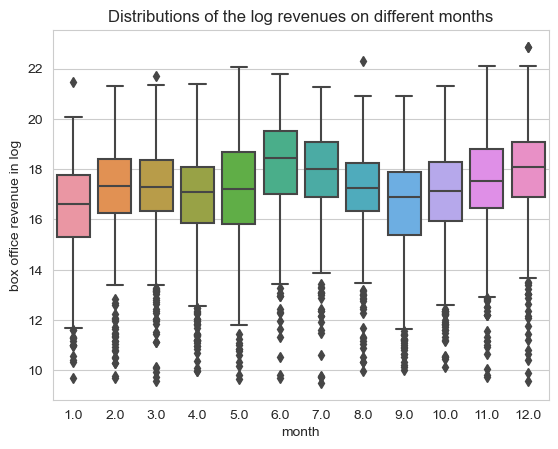

In [24]:
grouped_months = months_df.groupby("Month").mean('log_revenues')
# boxplot of the revenues for each month
sns.boxplot(x='Month', y='log_revenues', data=months_df)
plt.title("Distributions of the log revenues on different months")
plt.ylabel("box office revenue in log")
plt.xlabel("month")
plt.show()

We can see that movies released in july, december and february have highest box offices. Next, we check if there is a link between the percentage of woman actress and the box office revenue.

In [25]:
stats.spearmanr(gender_df['Percentage Women'], gender_df['log_revenues'])

SignificanceResult(statistic=-0.11100154328686704, pvalue=1.3189039414068337e-255)

Again, by running the spearman correlation test, we can see that the pvalue << 0.05 which rejects the null hypothesis that the box office revenues and percentage of women actresses are uncorrelated.

C:\Users\ratas\.conda\envs\ada\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


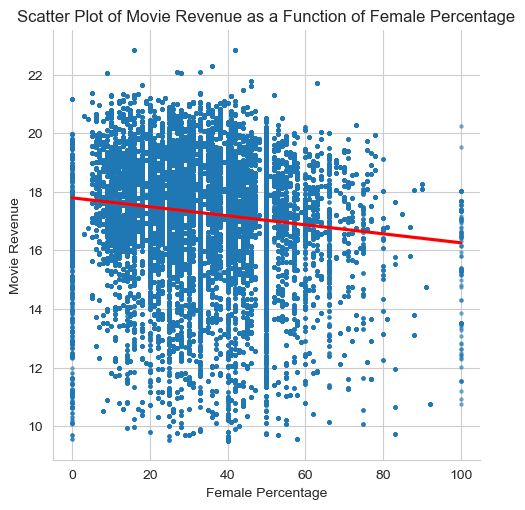

In [26]:
# Create a scatter plot
sns.lmplot(x='Percentage Women', y='log_revenues',data=gender_df,scatter_kws={'alpha':0.5, 's': 5},line_kws={'color': 'red'})

# Set labels and title
plt.xlabel('Female Percentage')
plt.ylabel('Movie Revenue')
plt.title('Scatter Plot of Movie Revenue as a Function of Female Percentage')

# Show the plot
plt.show()

We can see from the plot that most of the highest box office revenues have a low number of women actresses compared to men actors.

#### Actors

In [31]:
# Keep only the actors that appear in at least 20 movies
actors_in_20movies_df = actor_df.groupby('Actor name').filter(lambda x: len(x) >= 20)

# display(actors_in_20movies_df)

In [61]:
# Sort the actors by the mean log_revenues of their movies (mean of log_revenues is equivalent to geometric mean of revenues)
top_actors = actors_in_20movies_df.groupby('Actor name').mean('log_revenues').sort_values(by='log_revenues', ascending=False).reset_index()

#rescale log_revenues back to normal revenues (geometric mean)
top_actors['revenues_in_millions'] = np.exp(top_actors['log_revenues']) / 1e6

# display(top_actors)

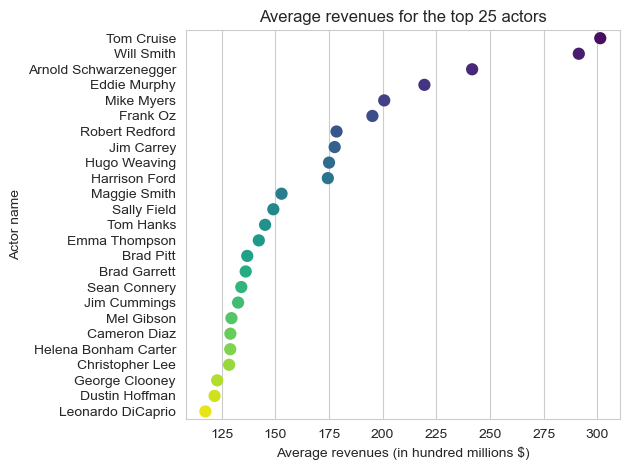

In [64]:
# Plot the mean
sns.pointplot(y='Actor name', x='revenues_in_millions', data=top_actors.head(25), palette='viridis', errorbar=None)
plt.title('Average revenues for the top 25 actors')
plt.xlabel('Average revenues (in hundred millions $)')
plt.ylabel('Actor name')
plt.tight_layout()
plt.show()

We are averaging log_revenues instead of revenues, which correspond to doing a geometric mean instead of an arithmetic mean. This is  useful to penalize the big variances in revenues, so we are favoring actor with consistency over the ones that only participated in a few hits. (For example, the top actors with arithmetic mean was resulting in many actors from harry potter or other saga. This is because there are many film in these saga with high revenues, boosting their mean revenue despite the actors didn't have only successful movies).

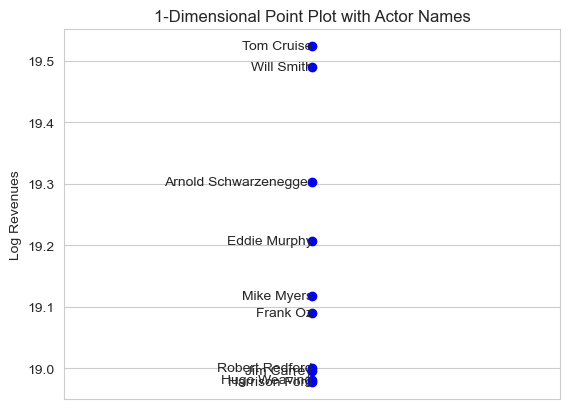

In [116]:
# PLOT IDEA: 1D point plot with actor names, interactive with scrolling wheel
top10_actor_mean = top_actors.head(10).reset_index()
actor_names = top10_actor_mean['Actor name']
log_revenues = top10_actor_mean['log_revenues']

# Create a scatter plot with labels
for actor, log_revenue in zip(actor_names, log_revenues):
    plt.scatter(0, log_revenue, marker='o', color='blue')  # Use log_revenue as the y-coordinate
    plt.text(0, log_revenue, actor, ha='right', va='center')

# Remove x-axis
plt.xticks([])

# Add labels and title
plt.ylabel('Log Revenues')
plt.title('1-Dimensional Point Plot with Actor Names')

# Display the plot
plt.show()


In [ ]:
import plotly.express as px

# Create a sample DataFrame
import pandas as pd
import numpy as np

np.random.seed(42)
data = pd.DataFrame({
    'X': np.random.rand(100),
    'Y': np.random.rand(100),
    'Label': np.random.choice(['A', 'B'], size=100)
})

# Create an interactive scatter plot
fig = px.scatter(data, x='X', y='Y', color='Label')

# Update layout to include zooming functionality
fig.update_layout(
    xaxis=dict(
        title='X-axis',
        rangeslider=dict(visible=True),  # Enable rangeslider for zooming
        type='linear'  # Set the type to 'linear' for a continuous x-axis
    ),
    yaxis=dict(
        title='Y-axis',
        type='linear'  # Set the type to 'linear' for a continuous y-axis
    )
)

# Show the plot
fig.show()


In [113]:
actor_reg = actors_in_20movies_df.drop(['Revenue with inflation'], axis=1)
actor_reg

,Actor name,log_revenues,Movie name
2,Ice Cube,16.957621,Ghosts of Mars
3,Jason Statham,16.957621,Ghosts of Mars
34,Christopher Walken,10.540183,New Rose Hotel
35,Willem Dafoe,10.540183,New Rose Hotel
72,Ving Rhames,17.698161,Baby Boy
...,...,...,...
100796,Jack Warden,17.651761,Guilty as Sin
100802,Ben Kingsley,13.908924,Twelfth Night: Or What You Will
100804,Helena Bonham Carter,13.908924,Twelfth Night: Or What You Will
100821,Jeffrey Wright,19.071369,Source Code


In [118]:
actor_reg = actor_reg.rename(columns={'Actor name': 'Actor_name'})

model = smf.ols(formula='log_revenues ~ C(Actor_name)', data=actor_reg)
mod = model.fit()
print(mod.summary())


                            OLS Regression Results                            
Dep. Variable:           log_revenues   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     2.589
Date:                Mon, 18 Dec 2023   Prob (F-statistic):           4.76e-82
Time:                        17:17:04   Log-Likelihood:                -36280.
No. Observations:               17352   AIC:                         7.379e+04
Df Residuals:                   16735   BIC:                         7.858e+04
Df Model:                         616                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

#### Movie runtime


We are first discretizing the movie runtime into meaningful fixed width intervals to break linearity and allow better interpretation of the results. This will also serve in the regression analysis later on.

In [66]:
# Define interval_range
movie_runtime_df['Interval'] = pd.cut(movie_runtime_df['Movie runtime'], bins=[0, 60, 90, 120, 150, 180, 210, 240, 1000], labels=['0-1h', '1h-1h30', '1h30-2h', '2h-2h30', '2h30-3h', '3h-3h30', '3h30-4h', '4h+'])

# display(movie_runtime_df)

,Movie runtime,log_revenues,Interval
0,98.0,16.957621,1h30-2h
1,123.0,17.698161,2h-2h30
2,103.0,15.838345,1h30-2h
3,87.0,18.583094,1h-1h30
4,113.0,19.267046,1h30-2h
...,...,...,...
8319,75.0,16.620940,1h-1h30
8320,147.0,18.002850,2h-2h30
8321,105.0,18.264864,1h30-2h
8322,98.0,16.970237,1h30-2h


C:\Users\ratas\AppData\Local\Temp\ipykernel_14812\4235565152.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x='Interval', y='log_revenues', data=movie_runtime_df, ci=95, capsize=.2, palette='viridis', ax=ax1)


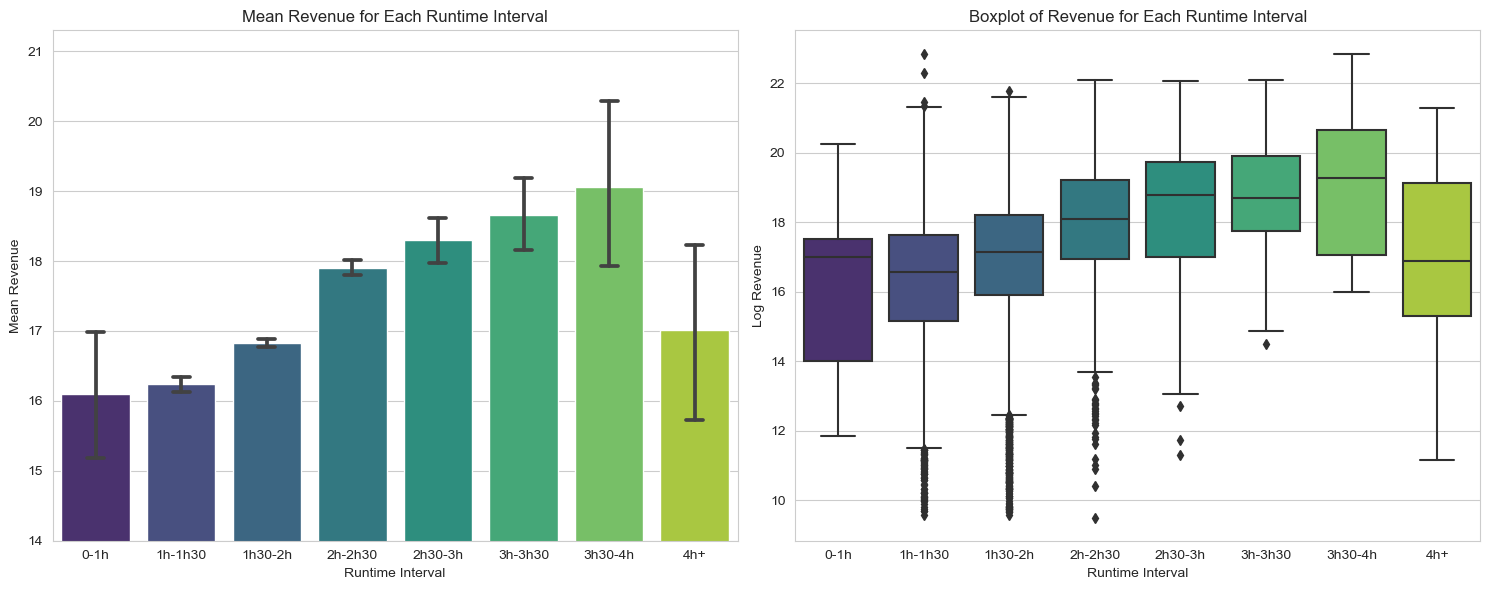

In [65]:
# Set up a multi-plot grid
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot the mean revenue with error bars and 95% confidence interval
sns.barplot(x='Interval', y='log_revenues', data=movie_runtime_df, ci=95, capsize=.2, palette='viridis', ax=ax1)
ax1.set_title('Mean Revenue for Each Runtime Interval')
ax1.set_xlabel('Runtime Interval in hours')
ax1.set_ylabel('Mean Revenue')
#limit axis 1 to (14, none)
ax1.set_ylim(14, None)

# Plot the boxplot
sns.boxplot(x='Interval', y='log_revenues', data=movie_runtime_df, palette='viridis', ax=ax2)
ax2.set_title('Boxplot of Revenue for Each Runtime Interval')
ax2.set_xlabel('Runtime Interval in hours')
ax2.set_ylabel('Log Revenue')

plt.tight_layout()
plt.show()

#### Movie genre

In [ ]:
movie_genres_reg_df = disagregate_list_feature(movie_genres_df, 'Movie Genres')

In [26]:
model = regression_analysis(movie_genres_reg_df, 'log_revenues')

                            OLS Regression Results                            
Dep. Variable:           log_revenues   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     11.65
Date:                Fri, 17 Nov 2023   Prob (F-statistic):               0.00
Time:                        23:46:25   Log-Likelihood:                -16600.
No. Observations:                8326   AIC:                         3.382e+04
Df Residuals:                    8015   BIC:                         3.601e+04
Df Model:                         310                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [27]:
display_regression_result(model)

Top 10 more successful features with coefficients and p-values:
                                                         Feature  \
Gross out                                              Gross out   
Historical Documentaries                Historical Documentaries   
Point of view shot                            Point of view shot   
Gay Interest                                        Gay Interest   
The Netherlands in World War II  The Netherlands in World War II   
Pornographic movie                            Pornographic movie   
Prison film                                          Prison film   
Inventions & Innovations                Inventions & Innovations   
Reboot                                                    Reboot   
Splatter film                                      Splatter film   

                                  Coefficient   p-value  
Gross out                        5.898839e+12  0.270034  
Historical Documentaries         5.746819e+00  0.001982  
Point of view

#### Movie countries

In [127]:
movie_countries_reg_df = disagregate_list_feature(movie_countries_df, 'Movie Countries')
movie_countries_reg_df

,log_revenues,Serbia,Weimar Republic,Kingdom of Great Britain,Kuwait,Belgium,Serbia and Montenegro,Netherlands,Pakistan,Algeria,...,Venezuela,Panama,Iran,Bahamas,Poland,United States of America,United Kingdom,Slovakia,Scotland,Lithuania
0,16.957621,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
1,17.698161,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
2,15.838345,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
3,18.583094,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
4,19.267046,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8321,18.264864,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
8322,16.970237,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
8323,17.571717,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
8324,17.186055,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False


In [149]:
#count sum each column
x = movie_countries_reg_df.sum(axis=0)
#keep only the lines with more than 100 movies
x = x[x > 50]
#keep only the columns with more than 100 movies
movie_countries_reg_df = movie_countries_reg_df[x.index]
movie_countries_reg_df

,log_revenues,Hong Kong,China,Japan,South Korea,France,Germany,Ireland,Australia,Spain,Italy,New Zealand,Canada,United States of America,United Kingdom
0,16.957621,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,17.698161,False,False,False,False,False,False,False,False,False,False,False,False,True,False
2,15.838345,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3,18.583094,False,False,False,False,False,True,False,True,False,False,False,True,True,False
4,19.267046,False,False,False,False,False,True,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8321,18.264864,False,False,False,False,False,False,False,False,False,False,False,False,True,False
8322,16.970237,False,False,False,False,False,False,False,False,False,False,False,False,True,False
8323,17.571717,False,False,False,False,False,False,False,False,False,False,False,False,True,False
8324,17.186055,False,False,False,False,False,False,False,False,False,False,False,False,True,False


In [134]:
model = regression_analysis(movie_countries_reg_df, 'log_revenues')

                            OLS Regression Results                            
Dep. Variable:           log_revenues   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     42.75
Date:                Mon, 18 Dec 2023   Prob (F-statistic):          2.11e-114
Time:                        19:21:01   Log-Likelihood:                -17860.
No. Observations:                8326   AIC:                         3.575e+04
Df Residuals:                    8311   BIC:                         3.585e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [135]:
display_regression_result(model)

Top 10 more successful features with coefficients and p-values:
                                           Feature  Coefficient       p-value
United States of America  United States of America     1.517894  3.553034e-90
China                                        China     1.092604  7.213572e-04
Japan                                        Japan     0.498869  8.619231e-04
Australia                                Australia     0.387139  2.633506e-02
Hong Kong                                Hong Kong     0.333744  2.055227e-01
Germany                                    Germany     0.311809  2.436741e-03
United Kingdom                      United Kingdom     0.300640  7.021833e-05
Italy                                        Italy     0.215688  2.208164e-01
France                                      France     0.060170  5.620917e-01
South Korea                            South Korea     0.032327  8.216126e-01
Top 10 more successful features with coefficients and p-values:
              

#### Movie languages

In [137]:
movie_languages_reg_df = disagregate_list_feature(movie_languages_df, 'Movie Languages')
movie_languages_reg_df

C:\Users\ratas\Documents\EPFL MA1\ADAFLIX\Project\ada-2023-project-adaflix\loads.py:92: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[feature] = result_df[feature_name].apply(lambda x: feature in x)
C:\Users\ratas\Documents\EPFL MA1\ADAFLIX\Project\ada-2023-project-adaflix\loads.py:92: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[feature] = result_df[feature_name].apply(lambda x: feature in x)
C:\Users\ratas\Documents\EPFL MA1\ADAFLIX\Project\ada-2023-project-adaflix\loads.py:92: PerformanceWarning: DataFram

,log_revenues,Zulu Language,Esperanto Language,Māori language,Hindi Language,Bulgarian Language,Sami languages,Italian,Malay Language,Slovak Language,...,German,Korean Sign Language,Filipino language,Ukrainian Language,Telugu language,Papiamento language,Yiddish Language,Mandarin Chinese,Standard Mandarin,Czech Language
0,16.957621,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,17.698161,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,15.838345,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,18.583094,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,19.267046,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8321,18.264864,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8322,16.970237,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8323,17.571717,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8324,17.186055,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [150]:
#count sum each column
x = movie_languages_reg_df.sum(axis=0)
#keep only the lines with more than 100 movies
x = x[x > 100]
#keep only the columns with more than 100 movies
movie_languages_reg_df = movie_languages_reg_df[x.index]
movie_languages_reg_df

,log_revenues,Japanese Language,German Language,Korean Language,Russian Language,English Language,Spanish Language,Italian Language,French Language,Standard Mandarin
0,16.957621,False,False,False,False,True,False,False,False,False
1,17.698161,False,False,False,False,True,False,False,False,False
2,15.838345,False,False,False,False,True,True,False,False,False
3,18.583094,False,False,False,False,True,False,False,False,False
4,19.267046,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
8321,18.264864,False,False,False,False,True,False,False,False,False
8322,16.970237,False,False,False,False,True,False,False,False,False
8323,17.571717,False,False,False,False,False,False,False,False,False
8324,17.186055,False,False,False,False,True,False,False,False,False


In [141]:
model = regression_analysis(movie_languages_reg_df, 'log_revenues')

                            OLS Regression Results                            
Dep. Variable:           log_revenues   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     58.05
Date:                Mon, 18 Dec 2023   Prob (F-statistic):          1.89e-103
Time:                        19:25:32   Log-Likelihood:                -17895.
No. Observations:                8326   AIC:                         3.581e+04
Df Residuals:                    8316   BIC:                         3.588e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                15.4387      0.08

In [142]:
display_regression_result(model)

Top 10 more successful features with coefficients and p-values:
                             Feature  Coefficient       p-value
English Language    English Language     1.494472  1.732396e-73
Standard Mandarin  Standard Mandarin     0.760808  9.364504e-05
Japanese Language  Japanese Language     0.714999  8.115376e-07
Spanish Language    Spanish Language     0.591485  1.468880e-08
Russian Language    Russian Language     0.526230  7.515752e-04
French Language      French Language     0.463122  1.965281e-06
Italian Language    Italian Language     0.446347  1.561041e-03
German Language      German Language     0.375427  5.140410e-03
Korean Language      Korean Language     0.159195  2.821926e-01
Top 10 more successful features with coefficients and p-values:
                             Feature  Coefficient       p-value
English Language    English Language     1.494472  1.732396e-73
Standard Mandarin  Standard Mandarin     0.760808  9.364504e-05
Japanese Language  Japanese Language    

In [153]:
# merge regression df on index
regression_df = pd.merge(movie_languages_reg_df, movie_countries_reg_df, left_index=True, right_index=True)
regression_df.drop(columns='log_revenues_y', inplace=True)

In [154]:
model = regression_analysis(regression_df, 'log_revenues_x')

                            OLS Regression Results                            
Dep. Variable:         log_revenues_x   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     37.17
Date:                Mon, 18 Dec 2023   Prob (F-statistic):          2.77e-157
Time:                        19:36:56   Log-Likelihood:                -17741.
No. Observations:                8326   AIC:                         3.553e+04
Df Residuals:                    8302   BIC:                         3.570e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [159]:
# print ordered coefficients with pvalues
print(model.params.sort_values(ascending=False))


const                       15.084202
United States of America     1.325250
China                        0.901055
French Language              0.721931
Japanese Language            0.687460
English Language             0.601631
Spanish Language             0.599133
Russian Language             0.569288
Standard Mandarin            0.520791
Italian Language             0.505271
German Language              0.438417
Korean Language              0.402629
Australia                    0.329549
Japan                        0.275416
Hong Kong                    0.227848
Germany                      0.208325
United Kingdom               0.188183
South Korea                  0.109018
New Zealand                  0.049555
Italy                        0.009566
Spain                       -0.162679
France                      -0.215180
Canada                      -0.471174
Ireland                     -0.658469
dtype: float64


In [163]:
# print highest pvalues rounded to 3 decimals
print(model.pvalues.sort_values(ascending=False).round(3))

Italy                       0.958
New Zealand                 0.857
South Korea                 0.681
Spain                       0.458
Hong Kong                   0.406
Korean Language             0.130
Japan                       0.122
Australia                   0.056
France                      0.049
Germany                     0.043
Standard Mandarin           0.027
Ireland                     0.015
United Kingdom              0.015
China                       0.010
German Language             0.001
Italian Language            0.000
Russian Language            0.000
Japanese Language           0.000
Canada                      0.000
Spanish Language            0.000
English Language            0.000
French Language             0.000
United States of America    0.000
const                       0.000
dtype: float64


# Soup regression formula (in progress)

In [34]:
movie_with_inflation

,Wikipedia movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie Languages,Movie Countries,Movie Genres,Year,Month,Revenue with inflation,log_revenues,year_intervals,runtime_intervals
0,975900,Ghosts of Mars,2001-08-24,14010832.0,98,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,8.0,2.315268e+07,16.957621,1994-2003,70-99
1,156558,Baby Boy,2001-06-27,29381649.0,123,[English Language],[United States of America],"[Crime Fiction, Drama, Coming of age]",2001,6.0,4.855272e+07,17.698161,1994-2003,100-129
2,5566878,Tortilla Soup,2001-08-24,4574762.0,103,"[English Language, Spanish Language]",[United States of America],"[Romantic comedy, Indie, Slice of life story, ...",2001,8.0,7.559723e+06,15.838345,1994-2003,100-129
3,570743,Down to Earth,2001-02-12,71186502.0,87,[English Language],"[United States of America, Australia, Canada, ...","[Romantic comedy, Romance Film, Fantasy, Comedy]",2001,2.0,1.176346e+08,18.583094,1994-2003,70-99
4,366111,Shallow Hal,2001-11-01,141069860.0,113,[English Language],"[United States of America, Germany]","[Romantic comedy, Fantasy, Comedy, Drama, Roma...",2001,11.0,2.331158e+08,19.267046,1994-2003,100-129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8319,68388,The General,1926-12-31,1000000.0,75,"[Silent film, English Language]",[United States of America],"[Romance Film, Action, Comedy, War film]",1926,12.0,1.653418e+07,16.620940,1924-1933,70-99
8320,4499436,Way Down East,1920,4500000.0,147,"[Silent film, English Language]",[United States of America],"[Silent film, Indie, Black-and-white, Action/A...",1920,NaN,6.584737e+07,18.002850,1914-1923,130-159
8321,1995966,The Singing Fool,1928-08-17,5000000.0,105,[English Language],[United States of America],"[Musical, Melodrama, Drama, Musical Drama, Bla...",1928,8.0,8.557164e+07,18.264864,1924-1933,100-129
8322,24587655,A Woman of Affairs,1928-12-15,1370000.0,98,"[Silent film, English Language]",[United States of America],"[Silent film, Melodrama, Drama, Film adaptatio...",1928,12.0,2.344663e+07,16.970237,1924-1933,70-99


In [ ]:
formula_df = movie_with_inflation.copy()
formula_df = disagregate_list_feature(formula_df, 'Movie Languages')
formula_df = disagregate_list_feature(formula_df, 'Movie Countries')
formula_df = disagregate_list_feature(formula_df, 'Movie Genres')

In [36]:
formula_df.drop(['Wikipedia movie ID', 'Movie name', 'Movie release date', 'Movie box office revenue', 'Year', 'Movie runtime', 'Revenue with inflation'], axis=1, inplace=True)
formula_df

,Month,log_revenues,year_intervals,runtime_intervals,Old English language,Standard Mandarin,Khmer language,American English,Sumerian,𐐖𐐲𐑉𐑋𐑌𐐲,...,Film & Television History,Short Film,Horror Comedy,Costume drama,Hagiography,World cinema,Space opera,Libraries and librarians,Wuxia,Documentary
0,8.0,16.957621,1994-2003,70-99,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,6.0,17.698161,1994-2003,100-129,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,8.0,15.838345,1994-2003,100-129,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,2.0,18.583094,1994-2003,70-99,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,11.0,19.267046,1994-2003,100-129,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8319,12.0,16.620940,1924-1933,70-99,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8320,NaN,18.002850,1914-1923,130-159,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8321,8.0,18.264864,1924-1933,100-129,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8322,12.0,16.970237,1924-1933,70-99,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [37]:
formula_df = pd.get_dummies(formula_df, columns=['Month', 'year_intervals', 'runtime_intervals'])
formula_df

,log_revenues,Old English language,Standard Mandarin,Khmer language,American English,Sumerian,𐐖𐐲𐑉𐑋𐑌𐐲,Sinhala Language,Sami languages,Navajo Language,...,year_intervals_1994-2003,year_intervals_2004-2013,runtime_intervals_10-39,runtime_intervals_40-69,runtime_intervals_70-99,runtime_intervals_100-129,runtime_intervals_130-159,runtime_intervals_160-189,runtime_intervals_190-219,runtime_intervals_221-1003
0,16.957621,False,False,False,False,False,False,False,False,False,...,True,False,False,False,True,False,False,False,False,False
1,17.698161,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,True,False,False,False,False
2,15.838345,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,True,False,False,False,False
3,18.583094,False,False,False,False,False,False,False,False,False,...,True,False,False,False,True,False,False,False,False,False
4,19.267046,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8319,16.620940,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
8320,18.002850,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
8321,18.264864,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
8322,16.970237,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False


In [38]:
model = regression_analysis(formula_df, 'log_revenues')

                            OLS Regression Results                            
Dep. Variable:           log_revenues   R-squared:                       0.452
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     11.29
Date:                Fri, 17 Nov 2023   Prob (F-statistic):               0.00
Time:                        23:46:30   Log-Likelihood:                -15466.
No. Observations:                8242   AIC:                         3.206e+04
Df Residuals:                    7679   BIC:                         3.601e+04
Df Model:                         562                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

# Work in progress

In [1]:
! pip install spacy
!pip install -U textblob
!pip install --user -U nltk
!python -m spacy download en_core_web_sm

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.7.1/en_core_web_sm-3.7.1-py3-none-any.whl (12.8 MB)
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [64]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
import spacy
import string
from scipy import stats
from textblob import TextBlob
from collections import Counter
from nltk.sentiment.util import *
from nltk.corpus import stopwords
from sklearn import preprocessing
from nltk.corpus import subjectivity
from nltk.tokenize import word_tokenize
from spacy.lang.en.examples import sentences
from nltk.sentiment import SentimentAnalyzer
from nltk.classify import NaiveBayesClassifier
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from scripts.helper import *
from scripts.plot import *
from loads import *
import os

nltk.download('punkt')
nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words('english'))
stop_words.add(string.punctuation)

PATH_FOLDER = "MovieSummaries/"

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\41794\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\41794\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Using the plot_summary dataset, we perform a sentiment analysis over each movie summary extracting positive and negative words to make another feature to predit box office revenues.

In [23]:
#create a copy for the summary metadata
summary_metadata_copy = plot_summaries_df.copy()
print(f"The shape of the summary metadata before removing duplicates is : {summary_metadata_copy.shape}")

#Remove duplicate values
summary_metadata_copy = summary_metadata_copy.drop_duplicates("Movie Summary")
print(f"The shape of the summary metadata after removing duplicates is : {summary_metadata_copy.shape}")

The shape of the summary metadata before removing duplicates is : (42303, 2)
The shape of the summary metadata after removing duplicates is : (42295, 2)


In [24]:
#add a column containing tokenized summaries into words
summary_metadata_copy.loc[:, 'tokenized_summary'] = summary_metadata_copy.apply(lambda x: tokenize(x['Movie Summary']), axis=1)

display(summary_metadata_copy)

,Movie ID,Movie Summary,tokenized_summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...","[Shlykov, a, taxi, driver, and, Lyosha, a, sax..."
1,31186339,The nation of Panem consists of a wealthy Capi...,"[The, nation, of, Panem, consists, of, a, weal..."
2,20663735,Poovalli Induchoodan is sentenced for six yea...,"[Poovalli, Induchoodan, is, sentenced, for, si..."
3,2231378,"The Lemon Drop Kid , a New York City swindler,...","[The, Lemon, Drop, Kid, a, New, York, City, sw..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...,"[Adventist, Church, pastor, Michael, Chamberla..."
...,...,...,...
42298,34808485,"The story is about Reema , a young Muslim scho...","[The, story, is, about, Reema, a, young, Musli..."
42299,1096473,"In 1928 Hollywood, director Leo Andreyev look...","[In, Hollywood, director, Leo, Andreyev, looks..."
42300,35102018,American Luthier focuses on Randy Parsons’ tra...,"[American, Luthier, focuses, on, Randy, Parson..."
42301,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se...","[Abdur, Rehman, Khan, a, dry, fruit, seller, f..."


In [25]:
#Filter the column containing tokenized text by deleting all stopwords
summary_metadata_copy.loc[:, 'filtered_Tokens'] = summary_metadata_copy['tokenized_summary'].apply(lambda tokens: [word for word in tokens if word.lower() not in stop_words])

display(summary_metadata_copy)

,Movie ID,Movie Summary,tokenized_summary,filtered_Tokens
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...","[Shlykov, a, taxi, driver, and, Lyosha, a, sax...","[Shlykov, taxi, driver, Lyosha, saxophonist, d..."
1,31186339,The nation of Panem consists of a wealthy Capi...,"[The, nation, of, Panem, consists, of, a, weal...","[nation, Panem, consists, wealthy, Capitol, tw..."
2,20663735,Poovalli Induchoodan is sentenced for six yea...,"[Poovalli, Induchoodan, is, sentenced, for, si...","[Poovalli, Induchoodan, sentenced, six, years,..."
3,2231378,"The Lemon Drop Kid , a New York City swindler,...","[The, Lemon, Drop, Kid, a, New, York, City, sw...","[Lemon, Drop, Kid, New, York, City, swindler, ..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...,"[Adventist, Church, pastor, Michael, Chamberla...","[Adventist, Church, pastor, Michael, Chamberla..."
...,...,...,...,...
42298,34808485,"The story is about Reema , a young Muslim scho...","[The, story, is, about, Reema, a, young, Musli...","[story, Reema, young, Muslim, schoolgirl, Mala..."
42299,1096473,"In 1928 Hollywood, director Leo Andreyev look...","[In, Hollywood, director, Leo, Andreyev, looks...","[Hollywood, director, Leo, Andreyev, looks, ph..."
42300,35102018,American Luthier focuses on Randy Parsons’ tra...,"[American, Luthier, focuses, on, Randy, Parson...","[American, Luthier, focuses, Randy, Parsons, t..."
42301,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se...","[Abdur, Rehman, Khan, a, dry, fruit, seller, f...","[Abdur, Rehman, Khan, dry, fruit, seller, Afgh..."


In [ ]:
#Initialize an empty list to store percentage of positive, negative and neutral words in each row of the 'filtered_Tokens' column
positive_scores = []
negative_scores = []
neutral_scores = []
sentiment_scores = []

#Perform sentiment analysis on each word
for liss in summary_metadata_copy['filtered_Tokens'] :

  # initialize all the counter to 0
  nbr_words_pos = 0
  nbr_words_neg = 0
  nbr_words_neu = 0
  nbr_words = 0

  for word in liss:
    nbr_words+= 1
    blob = TextBlob(word)
    #perform sentiment polarities of the word
    if (blob.sentiment.polarity > 0):
        nbr_words_pos += 1
    elif (blob.sentiment.polarity < 0):
        nbr_words_neg += 1
    else:
        nbr_words_neu += 1

  positive_scores.append(nbr_words_pos/nbr_words * 100)
  negative_scores.append(nbr_words_neg/nbr_words * 100)
  neutral_scores.append(nbr_words_neu/nbr_words * 100)

In [ ]:
#create columns to store percentage of positive, negative and neutral words in each row of the 'filtered_Tokens' column
summary_metadata_copy.loc[:,"percentage of positive words"] = positive_scores
summary_metadata_copy.loc[:,"percentage of negative words"] = negative_scores
summary_metadata_copy.loc[:,"percentage of neutral words"] = neutral_scores
summary_metadata_copy.head(5)

In [ ]:
# Merge the movie and summary dataframes based on the "Movie ID"
movie_summary_metadata = pd.merge(movie_df, summary_metadata_copy, on="Movie ID", how='outer')

# Drop NAN values
movie_summary_metadata.dropna(inplace=True)

movie_summary_metadata.head(3)

## Using the plot_summary dataset, we use NER, or Named Entity Recognition, to identify and classify entities (objects, people, locations, dates, etc.) in each movie summary text, extracting different entities occurences in a text and computing a "score" over these occurences

In [100]:
#create a copy for the summary metadata
summary_metadata_scores = plot_summaries_df.copy()
print(f"The shape of the summary metadata before removing duplicates is : {summary_metadata_copy.shape}")

#Remove duplicate values
summary_metadata_scores = summary_metadata_scores.drop_duplicates("Movie Summary")
print(f"The shape of the summary metadata after removing duplicates is : {summary_metadata_copy.shape}")

The shape of the summary metadata before removing duplicates is : (42295, 4)
The shape of the summary metadata after removing duplicates is : (42295, 4)


In [101]:
#List of entity types and weights (weights are chosen manually)
entity_weights = {
    "PERSON": 1,
    "ORG": 1,
    "GPE": 1,
    "LOC": 1,
    "DATE": 0.5,
    "TIME": 0.5,
    "MONEY": 0.5,
    "PERCENT": 0.5,
    "QUANTITY": 0.5,
    "ORDINAL": 0.5,
    "CARDINAL": 0.5
}

#Function to calculate the score for a summary
def calculate_score(summary):
    doc = nlp(summary)

    # Calculate entity occurrences for each sentence
    sentence_scores = []
    for sentence in doc.sents:
        entity_counts = Counter([ent.label_ for ent in sentence.ents])
        sentence_score = sum(entity_counts.get(entity, 0) * weight for entity, weight in entity_weights.items())
        sentence_scores.append(sentence_score)
    #mean over scores of all sentences of each movie summary
    return np.mean(sentence_scores)


file_path = 'external_dataset/movie_score.csv' # Replace with the actual path to your file

if os.path.exists(file_path):
    score = pd.read_csv(file_path)
    summary_metadata_scores['Score'] = score['Score']
else:
    #Add a new column 'Scores' to the DataFrame
    summary_metadata_scores['Score'] = summary_metadata_scores["Movie Summary"].apply(calculate_score)

#Print the resulting DataFrame
display(summary_metadata_scores)

,Movie ID,Movie Summary,Score
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",1.000000
1,31186339,The nation of Panem consists of a wealthy Capi...,1.240385
2,20663735,Poovalli Induchoodan is sentenced for six yea...,2.230769
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",1.183673
4,595909,Seventh-day Adventist Church pastor Michael Ch...,1.633333
...,...,...,...
42298,34808485,"The story is about Reema , a young Muslim scho...",NaN
42299,1096473,"In 1928 Hollywood, director Leo Andreyev look...",NaN
42300,35102018,American Luthier focuses on Randy Parsons’ tra...,NaN
42301,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se...",NaN


In [102]:
# Save scores to avoid unnecessary recomputations each time needed
summary_metadata_scores[['Movie ID','Score']].to_csv('external_dataset/movie_score.csv', index=False)

In [ ]:
# Merge the movie and summary dataframes based on the "Movie ID"
movie_summary_metadata = pd.merge(movie_df, summary_metadata_copy, on="Movie ID", how='outer')

# Drop NAN values
movie_summary_metadata.dropna(inplace=True)

movie_summary_metadata.head(3)